##About
In this notebook, we will use the ARIMA/SARIMA model to forecast monthly use of energy by users.

##Dataset
PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The hourly power consumption data comes from PJM's website and are in megawatts (MW).

Link to dataset:<br>
https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption/data?select=AEP_hourly.csv

In [ ]:
# Install ARIMA
!pip install pmdarima

In [ ]:
# Import Libraries
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import math
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pmdarima as pm
import statsmodels.api as sm
from scipy import stats
from scipy.special import inv_boxcox
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

In [ ]:
# Read Dataset|
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/My Drive/Kaggle_hourly-energy-consumption/AEP_hourly.csv',
                   index_col=[0], parse_dates=[0])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


In [ ]:
df.tail()

,AEP_MW
Datetime,
2018-01-01 20:00:00,21089.0
2018-01-01 21:00:00,20999.0
2018-01-01 22:00:00,20820.0
2018-01-01 23:00:00,20415.0
2018-01-02 00:00:00,19993.0


In [ ]:
df.shape

(121273, 1)

In [ ]:
df.isnull().sum()

,0
AEP_MW,0


In [ ]:
# Resample the data to monthly frequency by taking the mean of the values for each month
df_monthly = df.resample('M').mean()

# Display the first few rows of the resampled data
df_monthly.head()

,AEP_MW
Datetime,
2004-10-31,13947.537736
2004-11-30,14830.440278
2004-12-31,16737.720430
2005-01-31,17117.088710
2005-02-28,16496.644345


## Step 1: Plot the Data
First, we visualize the time series data to identify any trends, seasonality, or unusual observations.

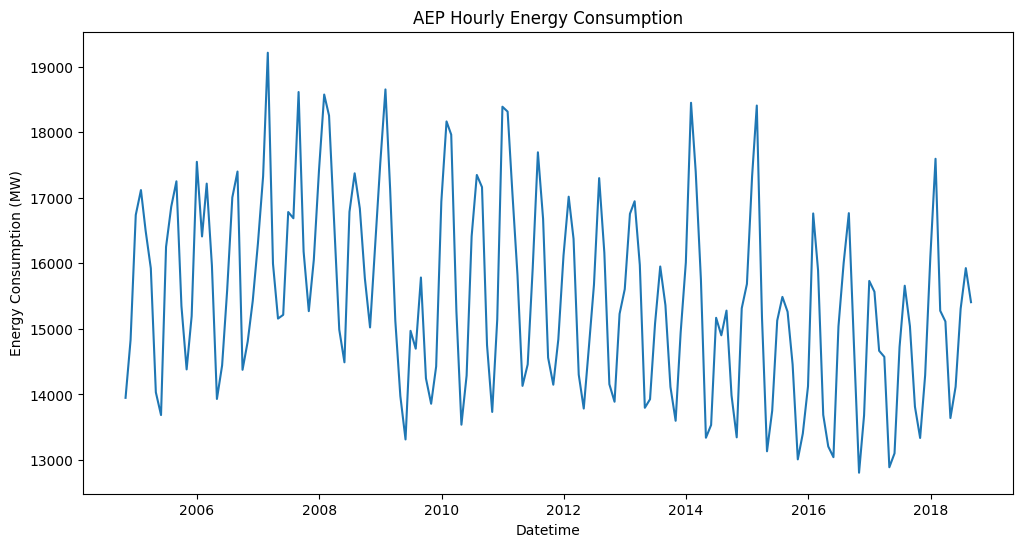

In [ ]:
# Plot the data
plt.figure(figsize = (12,6))
plt.plot(df_monthly.index, df_monthly['AEP_MW'])
plt.title('AEP Hourly Energy Consumption')
plt.xlabel('Datetime')
plt.ylabel('Energy Consumption (MW)')

plt.show()

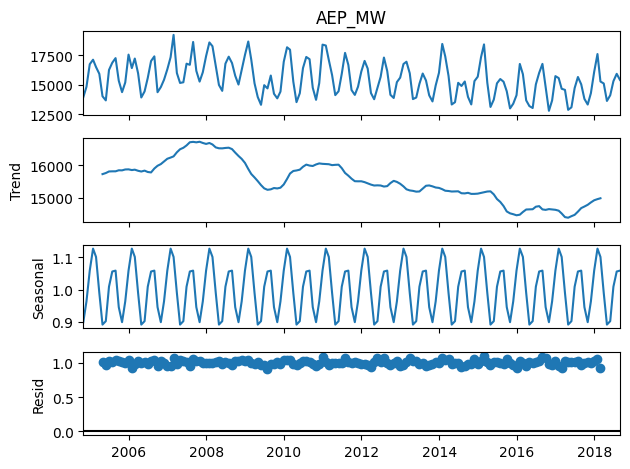

In [ ]:
# period=12: Assumes monthly seasonality.
decomposition = seasonal_decompose(df_monthly['AEP_MW'], model = 'multiplicative', period=12)

# Plot the decomposed components (Observed, Trend, Seasonal, and Residual)
decomposition.plot();

## Observation:
Trend: We can see a general increase in power consumption until around 2009, followed by a decline over the following years

Seasonal: The strong seasonal component suggests that power consumption follows a consistent yearly cycle

Residual: The residuals appear well-behaved, mostly random

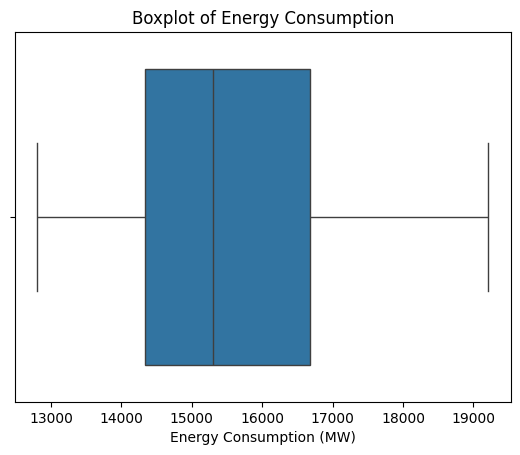

In [ ]:
# Check potential outliers with a boxplot
sns.boxplot(x = df_monthly['AEP_MW'])
plt.title('Boxplot of Energy Consumption')
plt.xlabel('Energy Consumption (MW)')
plt.show()

The plot suggests that the energy consumption distribution is fairly symmetric, with no outliers shown

## Step 2: Train/Test Split

In [ ]:
# Train with first 12 years and test last 2 years
train = df_monthly[df_monthly.index < '2016-01-01']['AEP_MW']
test = df_monthly[(df_monthly.index >= '2015-12-31')]['AEP_MW']

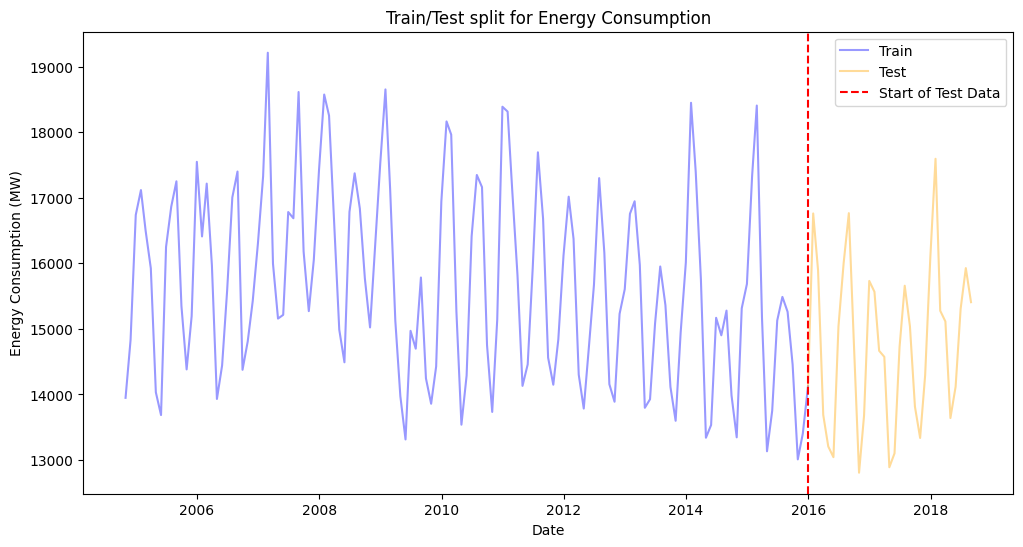

In [ ]:
# Plot the training data
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label = 'Train', color = 'blue', alpha = 0.4)

# Plot the testing data
plt.plot(test.index, test, label = 'Test', color = 'orange', alpha = 0.4)

# Add a vertical line at the boundary between the train and test datasets
plt.axvline(x=pd.to_datetime('2015-12-31'), color = 'red', linestyle = '--', label = 'Start of Test Data')

# Add some labels and a legend
plt.xlabel('Date')
plt.ylabel('Energy Consumption (MW)')
plt.title('Train/Test split for Energy Consumption')
plt.legend()

## Step 3: Differencing
If the data isn’t stationary, we difference the data until it appears stationary.

We will use one kind of unit root test, the ADF test, to check whether the data is stationary or not.

The ADF test checks for the presence of a unit root in a time series. A unit root indicates that the time series is non-stationary, meaning that it has some systematic pattern such as a trend, seasonality, or changing variance over time.

Hypothesis:

*   Null Hypothesis (H0): The time series has a unit root (i.e., it is non-stationary).
*   Alternative Hypothesis (H1): The time series does not have a unit root (i.e., it is stationary).



In [ ]:
# Perform the ADF test on the transformed data
adf_result = adfuller(train)

# Print the ADF test results
print(f'ADF Statistic: {adf_result[0]:.2f}')
print(f'p-value: {adf_result[1]:.2e}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value:.2f}')

ADF Statistic: -0.79
p-value: 8.23e-01
Critical Values:
   1%: -3.49
   5%: -2.89
   10%: -2.58


The p-value is 0.823, which is greater than any reasonable significance level (such as 0.01, 0.05, or 0.10). A high p-value suggests that we fail to reject the null hypothesis.

The null hypothesis for the ADF test is that the series has a unit root, meaning it is non-stationary.

Therefore, we should make the data stationary by differencing.

In [ ]:
train_diff = train.diff().dropna()
print(train_diff)

Datetime
2004-11-30     882.902542
2004-12-31    1907.280152
2005-01-31     379.368280
2005-02-28    -620.444364
2005-03-31    -572.582517
                 ...     
2015-08-31    -226.926075
2015-09-30    -803.127151
2015-10-31   -1448.604032
2015-11-30     394.129032
2015-12-31     720.189516
Freq: M, Name: AEP_MW, Length: 134, dtype: float64


In [ ]:
# Perform the ADF test on the transformed data
adf_result_diff = adfuller(train_diff)

# Print the ADF test results
print(f'ADF Statistic: {adf_result_diff[0]:.2f}')
print(f'p-value: {adf_result_diff[1]:.2e}')
print('Critical Values:')
for key, value in adf_result_diff[4].items():
    print(f'   {key}: {value:.2f}')

ADF Statistic: -5.41
p-value: 3.16e-06
Critical Values:
   1%: -3.49
   5%: -2.89
   10%: -2.58


After differencing, the p value is small, so we reject the null hypothesis and conclude that data is stationary

## Step 4: Plot ACF/PACF
We plot the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) to identify possible ARIMA model orders.

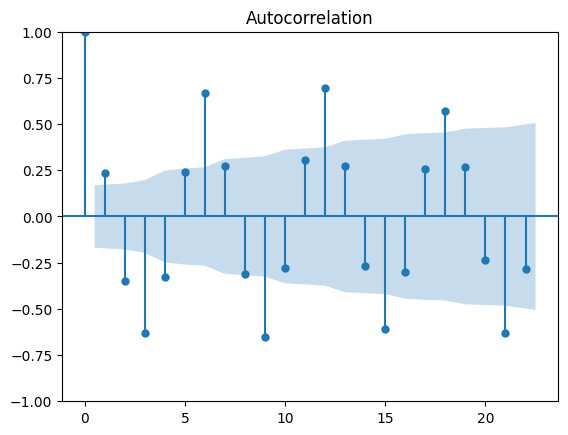

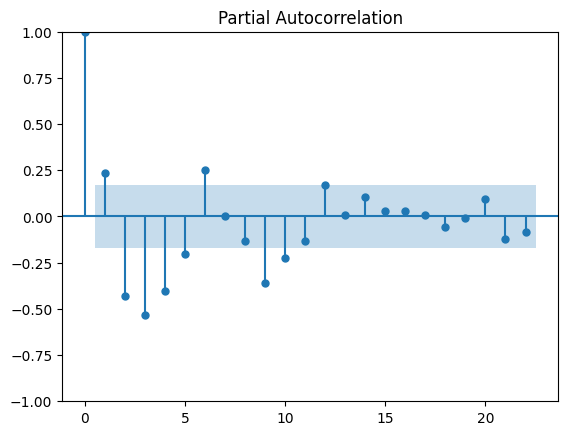

In [ ]:
plot_acf(train_diff)
plot_pacf(train_diff)
plt.show()

In the PACF plot, we see a strong significant spike at lag 1. So we can start with a p value of 1 in the sarima model.

In the ACF plot, we have a significant spike at lag 1 and then the values drop off. So a q value of 1 is suggested for the sarima model.

## Step 5: Select Model and Evaluate
Based on ACF and PACF plots, we select a few candidate SARIMA models and evaluate them using AIC and BIC

In [ ]:
# Fit SARIMA model with seasonal order (P, D, Q, S) where S=12 for monthly data with yearly seasonality
model_sarima_111 = SARIMAX(train_diff, order = (1,1,1), seasonal_order = (1,1,1,12))

# Fit the model
model_sarima_111_fit = model_sarima_111.fit()

# Print the summary of the model
print(model_sarima_111_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                             AEP_MW   No. Observations:                  134
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -978.061
Date:                            Tue, 24 Sep 2024   AIC                           1966.122
Time:                                    19:07:38   BIC                           1980.101
Sample:                                11-30-2004   HQIC                          1971.799
                                     - 12-31-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3525      0.083     -4.246      0.000      -0.515      -0.190
ma.L1         -1.0000      0.982   

In [ ]:
# Automatically determine the best combination of the SARIMA model parameters
smodel = pm.auto_arima(train_diff, start_p = 1, start_q = 1,
                         test = 'adf',
                         max_p = 3, max_q = 3, m = 12,
                         start_P = 0, seasonal = True, #seasonal = True indicates this is a sarima model
                         d = None, D = 1, trace = True,
                         error_action = 'ignore',
                         suppress_warnings = True,
                         stepwise = True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.35 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2024.922, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1993.153, Time=1.66 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1961.081, Time=1.70 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2022.962, Time=0.04 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=1994.036, Time=0.19 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.31 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=inf, Time=2.56 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=1980.045, Time=0.63 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=5.91 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1990.008, Time=3.32 sec
 ARIMA(0,0,2)(0,1,1)[12] intercept   : AIC=1960.297, Time=2.72 sec
 ARIMA(0,0,2)(0,1,0)[12] intercept   : AIC=1994.627, Time=0.21 sec
 ARIMA(0,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=1.84 sec
 ARIMA(0,0,2)(0,1,2)[12] intercept   : AIC=i

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  134
Model:             SARIMAX(0, 0, 2)x(0, 1, [1], 12)   Log Likelihood                -975.826
Date:                              Tue, 24 Sep 2024   AIC                           1959.652
Time:                                      19:11:30   BIC                           1970.868
Sample:                                  11-30-2004   HQIC                          1964.208
                                       - 12-31-2015                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5407      0.095     -5.682      0.000      -0.727      -0.354
ma.L2         -0.1679      0.099     -1.702      0.089      -0.361       0.025
ma.S.L12      -0.7660      0.103     -7.442      0.000      -0.968      -0.564
sigma2      4.814e+05   7.02e+04      6.858      0.000    3.44e+05    6.19e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 2.82
Prob(Q):                              0.94   Prob(JB):                         0.24
Heteroskedasticity (H):               0.89   Skew:                             0.37
Prob(H) (two-sided):                  0.71   Kurtosis:                         2.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

This sarima model seems to have a lower AIC and BIC value, so we will use this model parameters to train our sarima model

In [ ]:
# Fit SARIMA model with suggest parameters
model_sarima_002 = SARIMAX(train_diff, order = (0,0,2), seasonal_order = (0,1,1,12))

# Fit the model
model_sarima_002_fit = model_sarima_002.fit()

# Print the summary of the model
print(model_sarima_002_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                               AEP_MW   No. Observations:                  134
Model:             SARIMAX(0, 0, 2)x(0, 1, [1], 12)   Log Likelihood                -975.826
Date:                              Tue, 24 Sep 2024   AIC                           1959.652
Time:                                      19:15:47   BIC                           1970.868
Sample:                                  11-30-2004   HQIC                          1964.208
                                       - 12-31-2015                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5407      0.095     -5.682      0.000      -0.727      -0.354
ma.L2         -0.16

## Step 6: Check Residuals
We check the residuals of the selected model to ensure they behave like white noise.

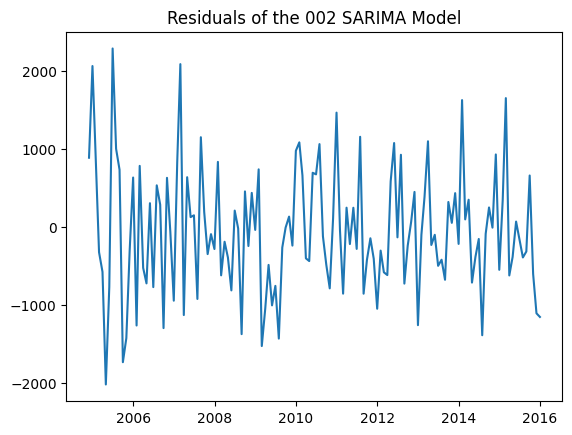

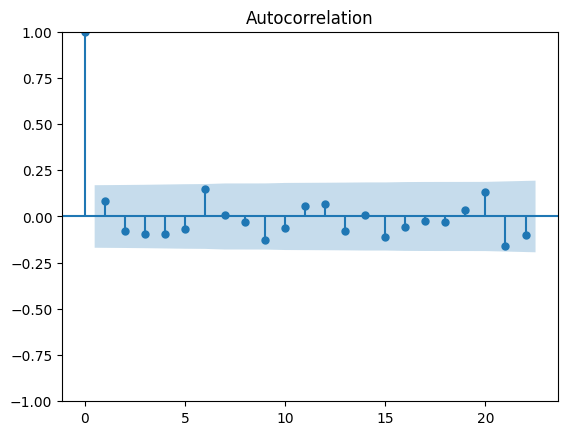

In [ ]:
# Plot residuals
residuals = model_sarima_002_fit.resid
plt.plot(residuals)
plt.title('Residuals of the 002 SARIMA Model')
plt.show()

# Plot ACF of residuals
plot_acf(residuals)
plt.show()

While the residuals roughly fluctuate around zero, there are some periods where the residuals are significantly high or low.

Since most of the autocorrelation values fall within the confidence interval, it suggests that the residuals are mostly uncorrelated, meaning that the SARIMA model has accounted for most of the time series structure.

## Step 7: Calculate Forecasts
If the residuals look like white noise, we use the model to forecast future sales.

In [ ]:
# Forecast 32 months into the future
forecast = model_sarima_002_fit.get_forecast(steps=32)

# Get confidence intervals for the forecast
forecast_ci = forecast.conf_int()

In [ ]:
# We need to convert back the data to its original scale (because we difference before)
# Get the last actual value from the original series
last_value = train.iloc[-1]

# Re-integrate the forecast by cumulatively summing and adding the last actual value
forecast_reintegrated = forecast.predicted_mean.cumsum() + last_value

# Re-integrate the lower and upper bounds of the confidence intervals
forecast_ci_reintegrated_lower = forecast_ci.iloc[:, 0] + last_value
forecast_ci_reintegrated_upper = forecast_ci.iloc[:, 1] + last_value

In [ ]:
# Generate a date range for the forecast period
forecast_index_32 = pd.date_range(start='2016-01-01', periods=32, freq='M')

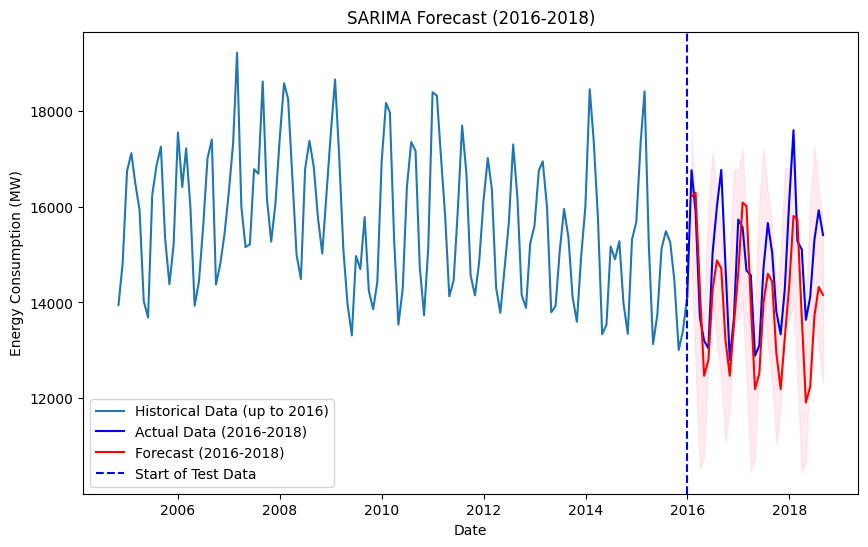

In [ ]:
# Plot the historical data
plt.figure(figsize=(10,6))
plt.plot(train, label='Historical Data (up to 2016)')
plt.plot(test, label='Actual Data (2016-2018)', color='blue')

# Plot the forecasted values
plt.plot(forecast_index_32, forecast_reintegrated, label='Forecast (2016-2018)', color='red')

# Plot the confidence intervals
plt.fill_between(forecast_index_32, forecast_ci_reintegrated_lower, forecast_ci_reintegrated_upper, color='pink', alpha=0.3)

# Add a vertical line at the boundary between the train and test datasets
plt.axvline(x=pd.to_datetime('2016-01-01'), color='blue', linestyle='--', label='Start of Test Data')

# Add labels and title
plt.title('SARIMA Forecast (2016-2018)')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.show()

## Observation:
The red forecast line closely follows the blue actual line, suggesting that the SARIMA model is doing a relatively good job of capturing the overall pattern of energy consumption during the test period.

The forecast (red line) also reflects the seasonal fluctuations that were present in the historical data, which is a sign that the SARIMA model has captured the seasonal pattern of energy consumption well.

However, slight deviations between the forecast and actual data suggest that further refinement might be required to improve the model accuracy.

We could see that the forecast has a downward trend, one reason might be in the training data, there is an upward trend until 2009, then it decays gradually until 2015, but started to increase again after 2015. SARIMA models are not robust to sudden trend change, therefore, this might affect the accuracy of the forecast.

## Next Step:

Find other models that could handle sudden trend change